# Mesa ABM of the Keep Threshold Relay

### Simulation notes and instructions

Notes:
* Nodes are created simulataneously using the Mesa SimultaneousActivation scheduler
* The nodes go through a bootstrap phase based on Antonio's diagram. They can only form groups if they are in the mainloop forked state.
* Relay requests are currently bernoulli trials
* Each step could be assumed to be a block
* Singature events are modeled by default as asynchronous with a step delay to mimick the block delay
* We assume that 1 node = 1 staker

Instructions:
1. Change variables
2. Click on the restart and run kernel icon for ipython


In [1]:
import random
import datetime
import numpy as np
import pandas as pd
import agent
import model
import matplotlib.pyplot as plt

**Initialize Variables**

In [2]:
# Group & Signature Parameters
group_size = 10 # number of virtual stakers in a group - nodes to stakers is a 1-many relationship
nodes = 10 # total number of nodes (assume 1 node = 1 staker)
active_group_threshold =10 # number of active groups to bootstrap at start
min_nodes = 3 # min number of nodes that must be online so as to increase the likelihood of lower max ownership
max_malicious_threshold = 40 # % of malicious node ownership needed to sign
signature_delay = 2 # lambda for poisson distribution used to generate a delay before the signature is executed
group_expiry = 14 # number of steps after which a group expires
Misbehaving_nodes = 10 # percent of nodes misbehaving during dkg
dkg_block_delay = 3 # blocks needed to run DKG
compromised_threshold = 0.25 # malicious + offline > threshold = compromised

#Node parameters
node_failure_percent = 10 # % of times nodes fail and have to reconnect
node_death_percent = 2 # % of time nodes fail and do not reconnect
node_connection_delay = 3 # max delay for a node to connect or reconnect after failure
node_mainloop_connection_delay = 3 # max delay for a node to fork or refork mainloop after failure

#Model Parameters
log_filename = 'master_sim.log'
run_number = 0

Text(0.5, 1.0, 'Virtual Staker Cumulative Distribution')

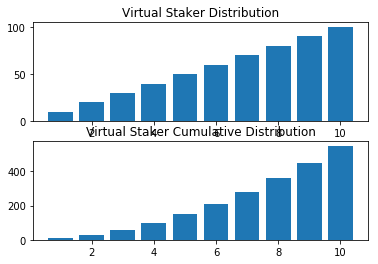

In [3]:
# Pre-processing Staker distributions
# Linear y = m * (x + 1) since indices start from 0
ticket_distribution = np.zeros(nodes) 

for i in range (0, nodes):
    ticket_distribution[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, ticket_distribution)
plt.title("Virtual Staker Distribution")

cdf_L02=model.create_cdf(nodes,ticket_distribution)
plt.subplot(2, 1, 2)
plt.bar(x, cdf_L02)
plt.title("Virtual Staker Cumulative Distribution")

In [4]:
beacon_model = model.Beacon_Model(nodes, ticket_distribution, 
                                  active_group_threshold, 
                                  group_size, 
                                  max_malicious_threshold, 
                                  group_expiry, 
                                  node_failure_percent, 
                                  node_death_percent, 
                                  signature_delay,
                                  min_nodes,
                                  node_connection_delay,
                                  node_mainloop_connection_delay,
                                  log_filename,
                                  run_number,
                                  Misbehaving_nodes,
                                  dkg_block_delay,
                                  compromised_threshold)

In [5]:
active_group_size = []
signature_failures = []
for i in range (100):
    beacon_model.step()

model_data = beacon_model.datacollector.get_model_vars_dataframe()
agent_data = beacon_model.datacollector.get_agent_vars_dataframe()

step # = 0##############################################
step # = 1##############################################
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
active group list length = 0
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
active group list length = 0
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
active group list length = 0
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
active group list length = 0
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
active group list length = 0
active group list length = 0
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
active group list length = 0
active group list length = 0
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
[1, 2, 4, 6, 7, 8, 9]
calculate offline = 1
[1, 2, 4, 6, 7, 8, 9]
calculate offlin

active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active group = 12
active group list length = 3
step # = 20##############################################
active group = 10
active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active group = 12
active group list length = 3
active group = 10
active group = 11
active grou

active group list length = 5
active group = 16
active group = 17
active group = 20
active group = 22
active group = 23
active group list length = 5
active group = 16
active group = 17
active group = 20
active group = 22
active group = 23
active group list length = 5
active group = 16
active group = 17
active group = 20
active group = 22
active group = 23
active group list length = 5
active group = 16
active group = 17
active group = 20
active group = 22
active group = 23
active group list length = 5
active group = 16
active group = 17
active group = 20
active group = 22
active group = 23
active group list length = 5
active group = 16
active group = 17
active group = 20
active group = 22
active group = 23
active group list length = 5
active group = 16
active group = 17
active group = 20
active group = 22
active group = 23
active group list length = 5
active group = 16
active group = 17
active group = 20
active group = 22
active group = 23
active group list length = 5
active group = 16
a

active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group = 25
active group list length = 1
active group 

active group = 43
active group = 44
active group list length = 5
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group list length = 5
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group list length = 5
[8]
calculate offline = 8
[8]
calculate offline = 8
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group list length = 5
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group list length = 5
step # = 76##############################################
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group list length = 5
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group list length = 5
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group list len

active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group = 45
active group list length = 6
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group = 45
active group list length = 6
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group = 45
active group list length = 6
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group = 45
active group list length = 6
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group = 45
active group list length = 6
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group = 45
active group list length = 6
active group = 39
active group = 41
active group = 42
active group = 43
active group = 44
active group = 45
active group list length = 6
active group = 39
active group = 41
activ

active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group = 51
active group list length = 1
active group 

3.0


Text(0, 0.5, 'active groups')

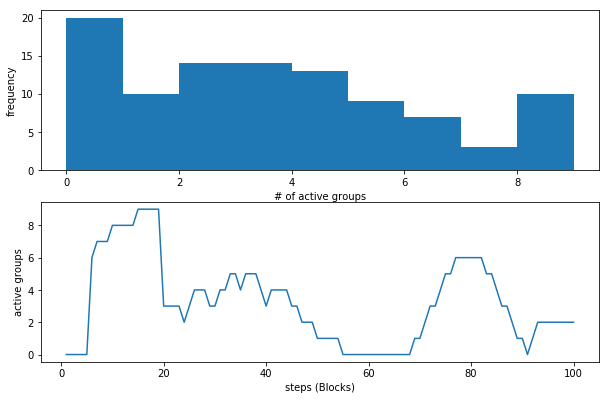

In [6]:
plt.figure(figsize = (10,10))
plt.subplot(3, 1, 1)
plt.hist(active_group_size, bins=range(max(active_group_size)+1))
plt.xlabel("# of active groups")
plt.ylabel("frequency")
print(np.median(active_group_size))

plt.subplot(3, 1, 2)
plt.plot(np.linspace(1,len(active_group_size),len(active_group_size)),active_group_size)
plt.xlabel("steps (Blocks)")
plt.ylabel("active groups")


**Further Questions**

* Whats the distribution of group ownership for each node that owns at least 1 group

In [7]:
# Calculate ownership distributions for the node(s) with the largest % ownership
node_ownership_percent= []
node_id = []
for node in beacon_model.schedule.agents:
    if node.type == "node":
        temp = []
        for group in beacon_model.schedule.agents:
            if group.type == "group":
                temp.append(round(group.ownership_distr[node.id]/sum(group.ownership_distr)*100))
        node_ownership_percent.append(temp)
        node_id.append(node.id)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 30. 10. 20. 10. 10. 30. 10.
  0. 50. 20. 10. 30.  0. 20. 10. 20. 30. 50. 30. 20. 20. 40.  0. 10. 30.
  0.  0. 70. 20.  0. 10. 20. 20. 10. 10. 20. 40. 20.  0. 30.  0. 20. 10.
 20. 10.  0. 20.]


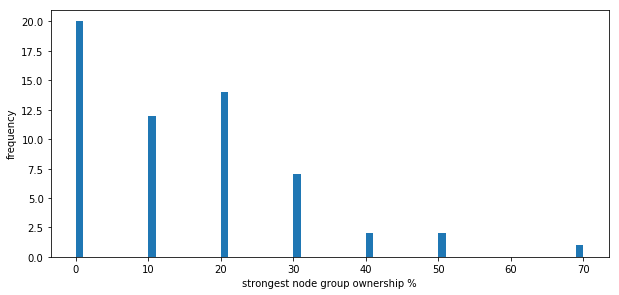

In [8]:
# Finds the nodes with max ownership % and the picks the one out of that group with the max cumulative total ownership
node_ownership_percent = np.array(node_ownership_percent)
max_node_indices = np.argwhere((node_ownership_percent>=np.amax(node_ownership_percent)))
#index = np.unravel_index(np.argmax(node_ownership_percent, axis=None), node_ownership_percent.shape)
#print(index)
node_ownership_sum = 0
max_node_index = []
for node in max_node_indices:
    #print(node[0])
    #print(sum(node_ownership_percent[node[0]]))
    if sum(node_ownership_percent[node[0]])>node_ownership_sum:
        node_ownership_sum = sum(node_ownership_percent[node[0]])
        max_node_index = node
    #print(max_node_index)
    
plt.figure(figsize = (10,10))
plt.subplot(2, 1, 1)
plt.hist(node_ownership_percent[max_node_index[0]], bins=range(int(max(node_ownership_percent[max_node_index[0]])+1)))
plt.xlabel("strongest node group ownership %")
plt.ylabel("frequency")
        
print(node_ownership_percent[max_node_index[0]])
        

* % of signatures dominated

In [9]:
# distribution of signature events dominated by each node
dominator_distr = np.zeros(nodes)
signature_count = 0
for signature in beacon_model.schedule.agents:
    if signature.type == "signature":
        signature_count+=1
        if signature.dominator_id>=0:
            dominator_distr[signature.dominator_id] += 1
            
print(dominator_distr)
print(signature_count)
            
        


[0. 0. 0. 1. 0. 6. 1. 2. 2. 2.]
37


In [10]:
agent_wealth = beacon_model.datacollector.get_agent_vars_dataframe()
agent_wealth.loc[30:31]

Type_ID       Type Node Status (Connection_Mainloop_Stake)  \
Step AgentID                                                               
30   0              0       node       not connectednot forkednot staked   
     1              1       node                   connectedforkedstaked   
     2              2       node                   connectedforkedstaked   
     3              3       node                   connectedforkedstaked   
     4              4       node               connectedforkednot staked   
     5              5       node                   connectedforkedstaked   
     6              6       node                   connectedforkedstaked   
     7              7       node                   connectedforkedstaked   
     8              8       node       not connectednot forkednot staked   
     9              9       node                   connectedforkedstaked   
     10             0      group                                    None   
     11             1      group                                    None   
     12             2      group                                    None   
     13             3      group                                    None   
     14             4      group                                    None   
     15             5      group                                    None   
     16             6      group                                    None   
     17             7      group                                    None   
     18             8      group                                    None   
     19             9      group                                    None   
     20            10      group                                    None   
     21            11      group                                    None   
     22             0  signature                                    None   
     23            12      group                                    None   
     24             1  signature                                    None   
     25            13      group                                    None   
     26             2  signature                                    None   
     27            14      group                                    None   
     28             3  signature                                    None   
     29            15      group                                    None   
...               ...        ...                                     ...   
31   14             4      group                                    None   
     15             5      group                                    None   
     16             6      group                                    None   
     17             7      group                                    None   
     18             8      group                                    None   
     19             9      group                                    None   
     20            10      group                                    None   
     21            11      group                                    None   
     22             0  signature                                    None   
     23            12      group                                    None   
     24             1  signature                                    None   
     25            13      group                                    None   
     26             2  signature                                    None   
     27            14      group                                    None   
     28             3  signature                                    None   
     29            15      group                                    None   
     30             4  signature                                    None   
     31            16      group                                    None   
     32             5  signature                                    None   
     33            17      group                              

In [11]:
gini = beacon_model.datacollector.get_model_vars_dataframe()
gini

,# of Active groups,# of Active Nodes
0,0,4
1,0,3
2,0,6
3,0,9
4,0,9
5,6,9
6,7,9
7,7,8
8,7,10
9,8,9
